<a href="https://colab.research.google.com/github/marisbotero/ML/blob/master/sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

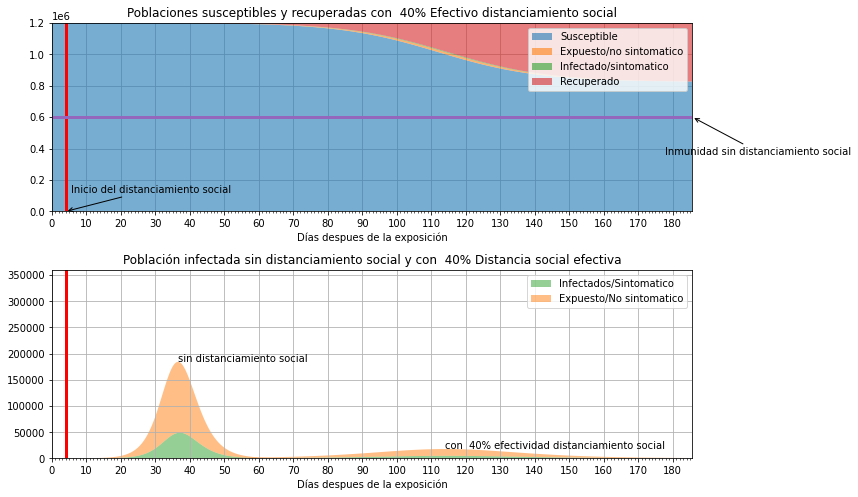

In [103]:
#@title SEIR Model with Social Distancing { run: "auto" }
#@markdown 
#@markdown Reproduction number
R0 = 2 #@param {type:"slider", min:0.9, max:5, step:0.1}
#@markdown Disease periods in days
t_incubation = 14 #@param {type:"slider", min:1, max:20, step:0.1}
t_infective = 5.1 #@param {type:"slider", min:0, max:14, step:0.1}
#@markdown Population Size
N = 1200000 #@param {type:"slider", min:1000, max:49000000, step:100}
#@markdown Initial number exposed
n = 10 #@param {type:"slider", min:0, max:100, step:1}
#@markdown Start of social distancing following exposure (weeks)
t_social_distancing = 4 #@param {type:"slider", min:0, max:30, step:0.1}
#@markdown Effectiveness of social distancing (0 to 100%)
u_social_distancing = 40 #@param {type:"slider", min:0, max:100, step:1}

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns

# initial number of infected and recovered individuals
e_initial = 10/N
i_initial = 0.00
r_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial

alpha = 1/t_incubation
gamma = 1/t_infective
beta = R0*gamma

def step(t):
    return 1 if t >= 7*t_social_distancing else 0

# SEIR model differential equations.
def deriv(x, t, u, alpha, beta, gamma):
    s, e, i, r = x
    dsdt = -(1-u*step(t)/100)*beta * s * i
    dedt =  (1-u*step(t)/100)*beta * s * i - alpha * e
    didt = alpha * e - gamma * i
    drdt =  gamma * i
    return [dsdt, dedt, didt, drdt]

t = np.linspace(0, 1300, 1300)
x_initial = s_initial, e_initial, i_initial, r_initial
s, e, i, r = odeint(deriv, x_initial, t, args=(u_social_distancing, alpha, beta, gamma)).T
s0, e0, i0, r0 = odeint(deriv, x_initial, t, args=(0, alpha, beta, gamma)).T

# plot the data



fig = plt.figure(figsize=(12, 10))
ax = [fig.add_subplot(311, axisbelow=True), 
      fig.add_subplot(312)]

pal = sns.color_palette()

ax[0].stackplot(t/7, N*s, N*e, N*i, N*r, colors=pal, alpha=0.6)
ax[0].set_title('Poblaciones susceptibles y recuperadas con {0:3.0f}% Efectivo distanciamiento social'.format(u_social_distancing))
ax[0].set_xlabel('Días despues de la exposición')
ax[0].set_xlim(0, t[-1]/7)
ax[0].set_ylim(0, N)
ax[0].legend([
    'Susceptible', 
    'Expuesto/no sintomatico', 
    'Infectado/sintomatico',
    'Recuperado'], 
    loc='best')
ax[0].plot(np.array([t_social_distancing, t_social_distancing]), ax[0].get_ylim(), 'r', lw=3)
ax[0].plot(np.array([0, t[-1]])/7, [N/R0, N/R0], lw=3, label='Inmunidad')
ax[0].annotate("Inicio del distanciamiento social",
    (t_social_distancing, 0), (t_social_distancing + 1.5, N/10),
    arrowprops=dict(arrowstyle='->'))
ax[0].annotate("Inmunidad sin distanciamiento social",
    (t[-1]/7, N/R0), (t[-1]/7 - 8, N/R0 - N/5),
    arrowprops=dict(arrowstyle='->'))

ax[1].stackplot(t/7, N*i0,N*e0, colors=pal[2:0:-1], alpha=0.5)
ax[1].stackplot(t/7, N*i, N*e, colors=pal[2:0:-1], alpha=0.5)
ax[1].set_title('Población infectada sin distanciamiento social y con {0:3.0f}% Distancia social efectiva'.format(u_social_distancing))
ax[1].set_xlim(0, t[-1]/7)
ax[1].set_ylim(0, max(0.3*N, 1.05*max(N*(e + i))))
ax[1].set_xlabel('Días despues de la exposición')
ax[1].legend([
    'Infectados/Sintomatico', 
    'Expuesto/No sintomatico'],
    loc='upper right')
ax[1].plot(np.array([t_social_distancing, t_social_distancing]), ax[0].get_ylim(), 'r', lw=3)

y0 = N*(e0 + i0)
k0 = np.argmax(y0)
ax[1].annotate("sin distanciamiento social", (t[k0]/7, y0[k0] + 100))

y = N*(e + i)
k = np.argmax(y)
ax[1].annotate("con {0:3.0f}% efectividad distanciamiento social ".format(u_social_distancing), (t[k]/7, y[k] + 100))

for a in ax:
    a.xaxis.set_major_locator(plt.MultipleLocator(10))
    a.xaxis.set_minor_locator(plt.MultipleLocator(1))
    a.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
   
    a.grid(True)

plt.tight_layout()

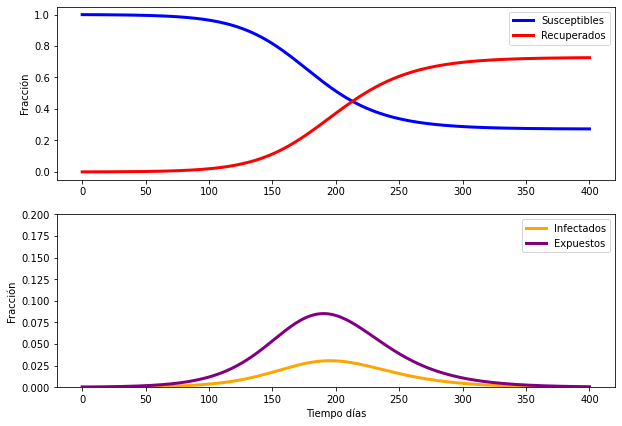

In [105]:

import numpy as np
from gekko import GEKKO
import matplotlib.pyplot as plt

t_incubation = 14
t_infective = 5.1
R0 = 1.8
N = 2427

# initial number of infected and recovered individuals
e_initial = 1/N
i_initial = 0.00
r_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial

alpha = 1/t_incubation
gamma = 1/t_infective
beta = R0*gamma

m = GEKKO()
u = m.FV(0)
s,e,i,r = m.Array(m.Var,4)
s.value = s_initial
e.value = e_initial
i.value = i_initial
s.value = s_initial
m.Equations([s.dt()==-(1-u)*beta * s * i,\
             e.dt()== (1-u)*beta * s * i - alpha * e,\
             i.dt()==alpha * e - gamma * i,\
             r.dt()==gamma*i])

t = np.linspace(0, 400, 201)
t = np.insert(t,1,[0.001,0.002,0.004,0.008,0.02,0.04,0.08,\
                   0.2,0.4,0.8])
m.time = t
m.options.IMODE=7
m.solve(disp=False)

# plot the data
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(m.time, s.value, color='blue', lw=3, label='Susceptibles')
plt.plot(m.time, r.value, color='red',  lw=3, label='Recuperados')
plt.ylabel('Fracción')
plt.legend()

plt.subplot(2,1,2)
plt.plot(m.time, i.value, color='orange', lw=3, label='Infectados')
plt.plot(m.time, e.value, color='purple', lw=3, label='Expuestos')
plt.ylim(0, 0.2)
plt.xlabel('Tiempo días')
plt.ylabel('Fracción')
plt.legend()

plt.show()


In [3]:
!pip install gekko

     |████████████████████████████████| 9.8MB 3.6MB/s 


apm 35.233.252.77_gk_model52 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 0.9.2
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            0
   Connections  :            0
   Equations    :            5
   Residuals    :            5
 
 Variable time shift OFF
 Number of state variables:           4598
 Number of total equations: -         4389
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :            209
 
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


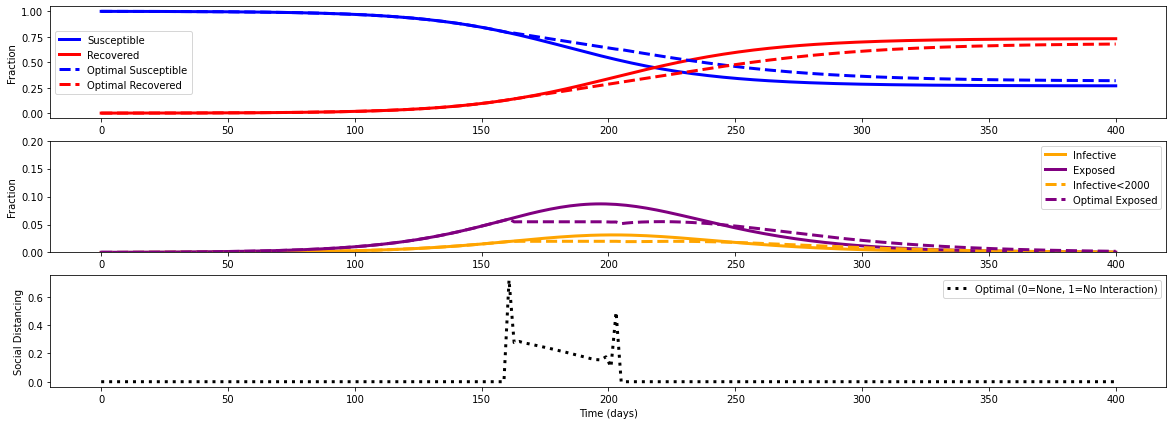

In [107]:
import numpy as np
from gekko import GEKKO
import matplotlib.pyplot as plt

t_incubation = 14
t_infective = 5.1
R0 = 1.8
N = 2500

# fraction of infected and recovered individuals
e_initial = 1/N
i_initial = 0.00
r_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial

alpha = 1/t_incubation
gamma = 1/t_infective
beta = R0*gamma

m = GEKKO()
u = m.MV(0,lb=0.0,ub=0.8)

s,e,i,r = m.Array(m.Var,4)
s.value = s_initial
e.value = e_initial
i.value = i_initial
r.value = r_initial
m.Equations([s.dt()==-(1-u)*beta * s * i,\
             e.dt()== (1-u)*beta * s * i - alpha * e,\
             i.dt()==alpha * e - gamma * i,\
             r.dt()==gamma*i])

t = np.linspace(0, 400, 200)
t = np.insert(t,1,[0.001,0.002,0.004,0.008,0.02,0.04,0.08,\
                   0.2,0.4,0.8])
m.time = t

# initialize with simulation
m.options.IMODE=7
m.options.NODES=3
m.solve(disp=False)

# plot the prediction
plt.figure(figsize=(20,7))
plt.subplot(3,1,1)
plt.plot(m.time, s.value, color='blue', lw=3, label='Susceptible')
plt.plot(m.time, r.value, color='red',  lw=3, label='Recovered')

plt.subplot(3,1,2)
plt.plot(m.time, i.value, color='orange', lw=3, label='Infective')
plt.plot(m.time, e.value, color='purple', lw=3, label='Exposed')

# optimize
m.options.IMODE=6
i.UPPER = 0.02
u.STATUS = 1
m.options.SOLVER = 3
m.options.TIME_SHIFT = 0
s.value = s.value.value
e.value = e.value.value
i.value = i.value.value
r.value = r.value.value
m.Minimize(u)
m.solve(disp=True)

# plot the optimized response
plt.subplot(3,1,1)
plt.plot(m.time, s.value, color='blue', lw=3, ls='--', label='Optimal Susceptible')
plt.plot(m.time, r.value, color='red',  lw=3, ls='--', label='Optimal Recovered')
plt.ylabel('Fraction')
plt.legend()

plt.subplot(3,1,2)
plt.plot(m.time, i.value, color='orange', ls='--', lw=3, label='Infective<2000')
plt.plot(m.time, e.value, color='purple', ls='--', lw=3, label='Optimal Exposed')
plt.ylim(0, 0.2)
plt.ylabel('Fraction')
plt.legend()

plt.subplot(3,1,3)
plt.plot(m.time, u.value, 'k:', lw=3, label='Optimal (0=None, 1=No Interaction)')
plt.ylabel('Social Distancing')
plt.legend()

plt.xlabel('Time (days)')

plt.show()